In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

In [2]:
import os 

import pickle

import numpy as np

import pandas as pd

import statsmodels.api as sm

import arviz as az
import pymc3 as pm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from modules.models.stats import LMMPerformance
from modules.utils.general_utils.stats_utils import compute_cd_from_regression

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['figure.dpi']        = 100
    matplotlib.rcParams['axes.linewidth']    = 1
    matplotlib.rcParams['xtick.major.width'] = 1
    matplotlib.rcParams['ytick.major.width'] = 1
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 13
    matplotlib.rcParams['axes.titlesize']    = 13
    matplotlib.rcParams['axes.labelsize']    = 13
    matplotlib.rcParams['legend.fontsize']   = 13
    matplotlib.rcParams['xtick.labelsize']   = 13
    matplotlib.rcParams['ytick.labelsize']   = 13
    
sns_styleset()

# Load Data

In [4]:
final_results = []

for fold_n in range(10):
    
    final_results.append(
        pd.read_csv(f'results\\tables\\models_performance\\models_performance_fold_{fold_n}.csv')
    )

final_results = pd.concat(final_results, ignore_index=True)
final_results = final_results.dropna()
final_results['time_epochs'] = final_results['fitting_time'] / final_results['epochs']
final_results['Model'] = final_results['Model'].map(
    {
        'Lag 1': 'Lag 1',
        'Median': 'Median',
        'TD E-Net': 'ENet',
        'TD MLP': 'MLP',
        'RNN': 'RNN'
    }
)

targets = final_results['target'].unique()
comparisons = [
    ('Lag 1', 'Median'), 
    ('Median', 'ENet'), 
    ('ENet', 'MLP'), 
    ('MLP','RNN')
]
final_results.to_csv('results\\tables\\models_performance\\models_performance_total.csv')
final_results['value'] = final_results['value'] * 100

In [5]:
collapsed_target = final_results.groupby(['Model', 'Session', 'context', 'fold_n'])['value'].sum().reset_index()
collapsed_target['value'] = collapsed_target['value'] / 5
collapsed_time = final_results.groupby(['Model', 'target', 'fold_n', 'context'])['value'].mean().reset_index()
collapsed_context = final_results.groupby(['Model', 'target', 'fold_n', 'Session'])['value'].mean().reset_index()

In [7]:
with (open('results\\saved_data_containers\\melchior.pkl', 'rb')) as container:
    data_container = pickle.load(container)

# Performance Visualization

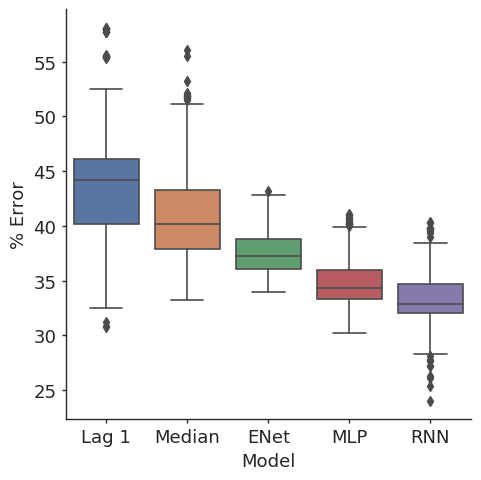

In [17]:
plt.figure(figsize=(5, 5))
ax = sns.boxplot(
    x='Model', 
    y='value', 
    data=collapsed_target, 
    order=['Lag 1', 'Median', 'ENet', 'MLP', 'RNN']
)
plt.ylabel('% Error')
sns.despine()
plt.tight_layout()
plt.show()

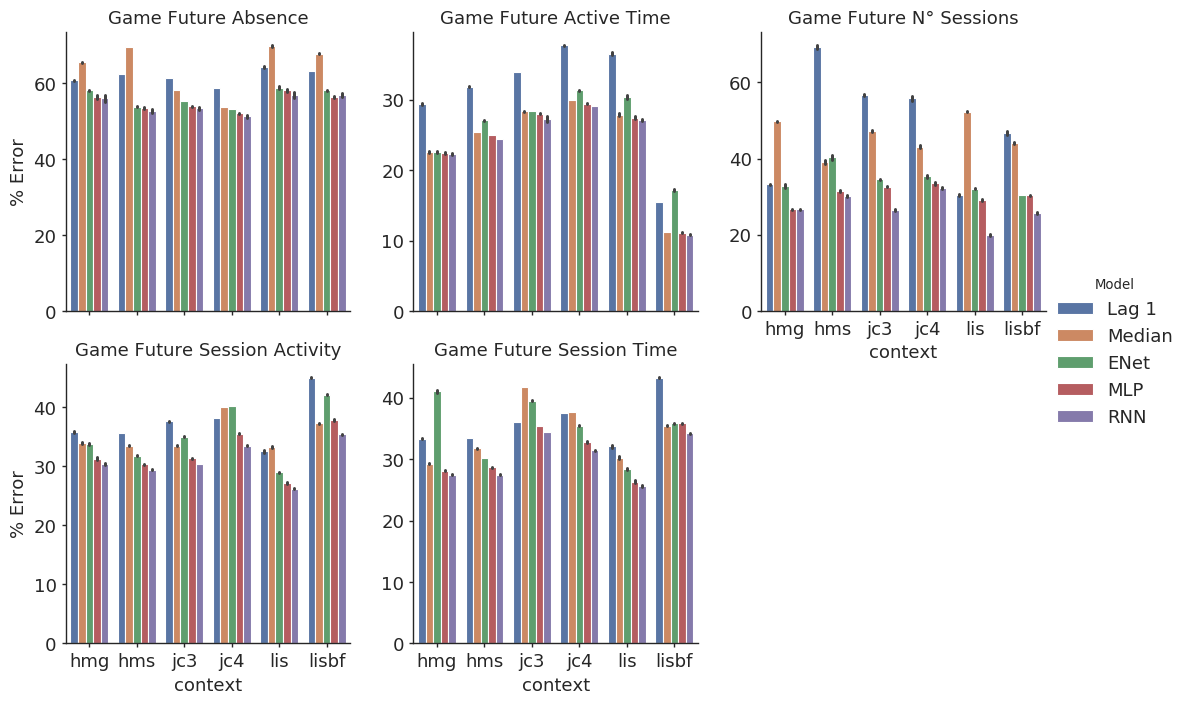

In [18]:
box_plots = sns.catplot(
    x='context', 
    y='value', 
    col='target',
    hue='Model',
    kind='bar',
    data=collapsed_time,
    hue_order=['Lag 1', 'Median', 'ENet', 'MLP', 'RNN'],
    col_wrap=3,
    height=3.5,
    sharey=False
)
box_plots.set_titles('Game {col_name}')
box_plots.set_ylabels('% Error')
plt.show()

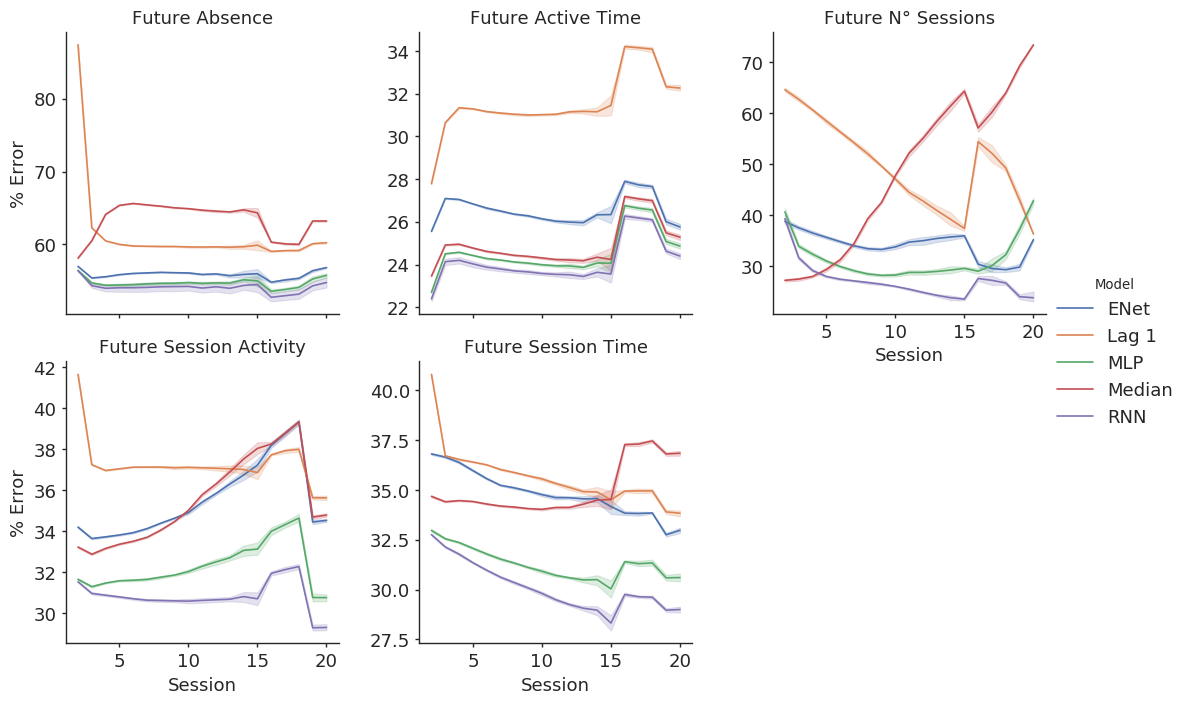

In [19]:
line_plots = sns.relplot(
    x='Session', 
    y='value', 
    hue='Model',
    col='target',
    kind='line',
    data=collapsed_context,
    col_wrap=3,
    height=3.5,
    facet_kws={'sharey': False}
)
line_plots.set_titles('{col_name}')
line_plots.set_ylabels('% Error')
plt.show()

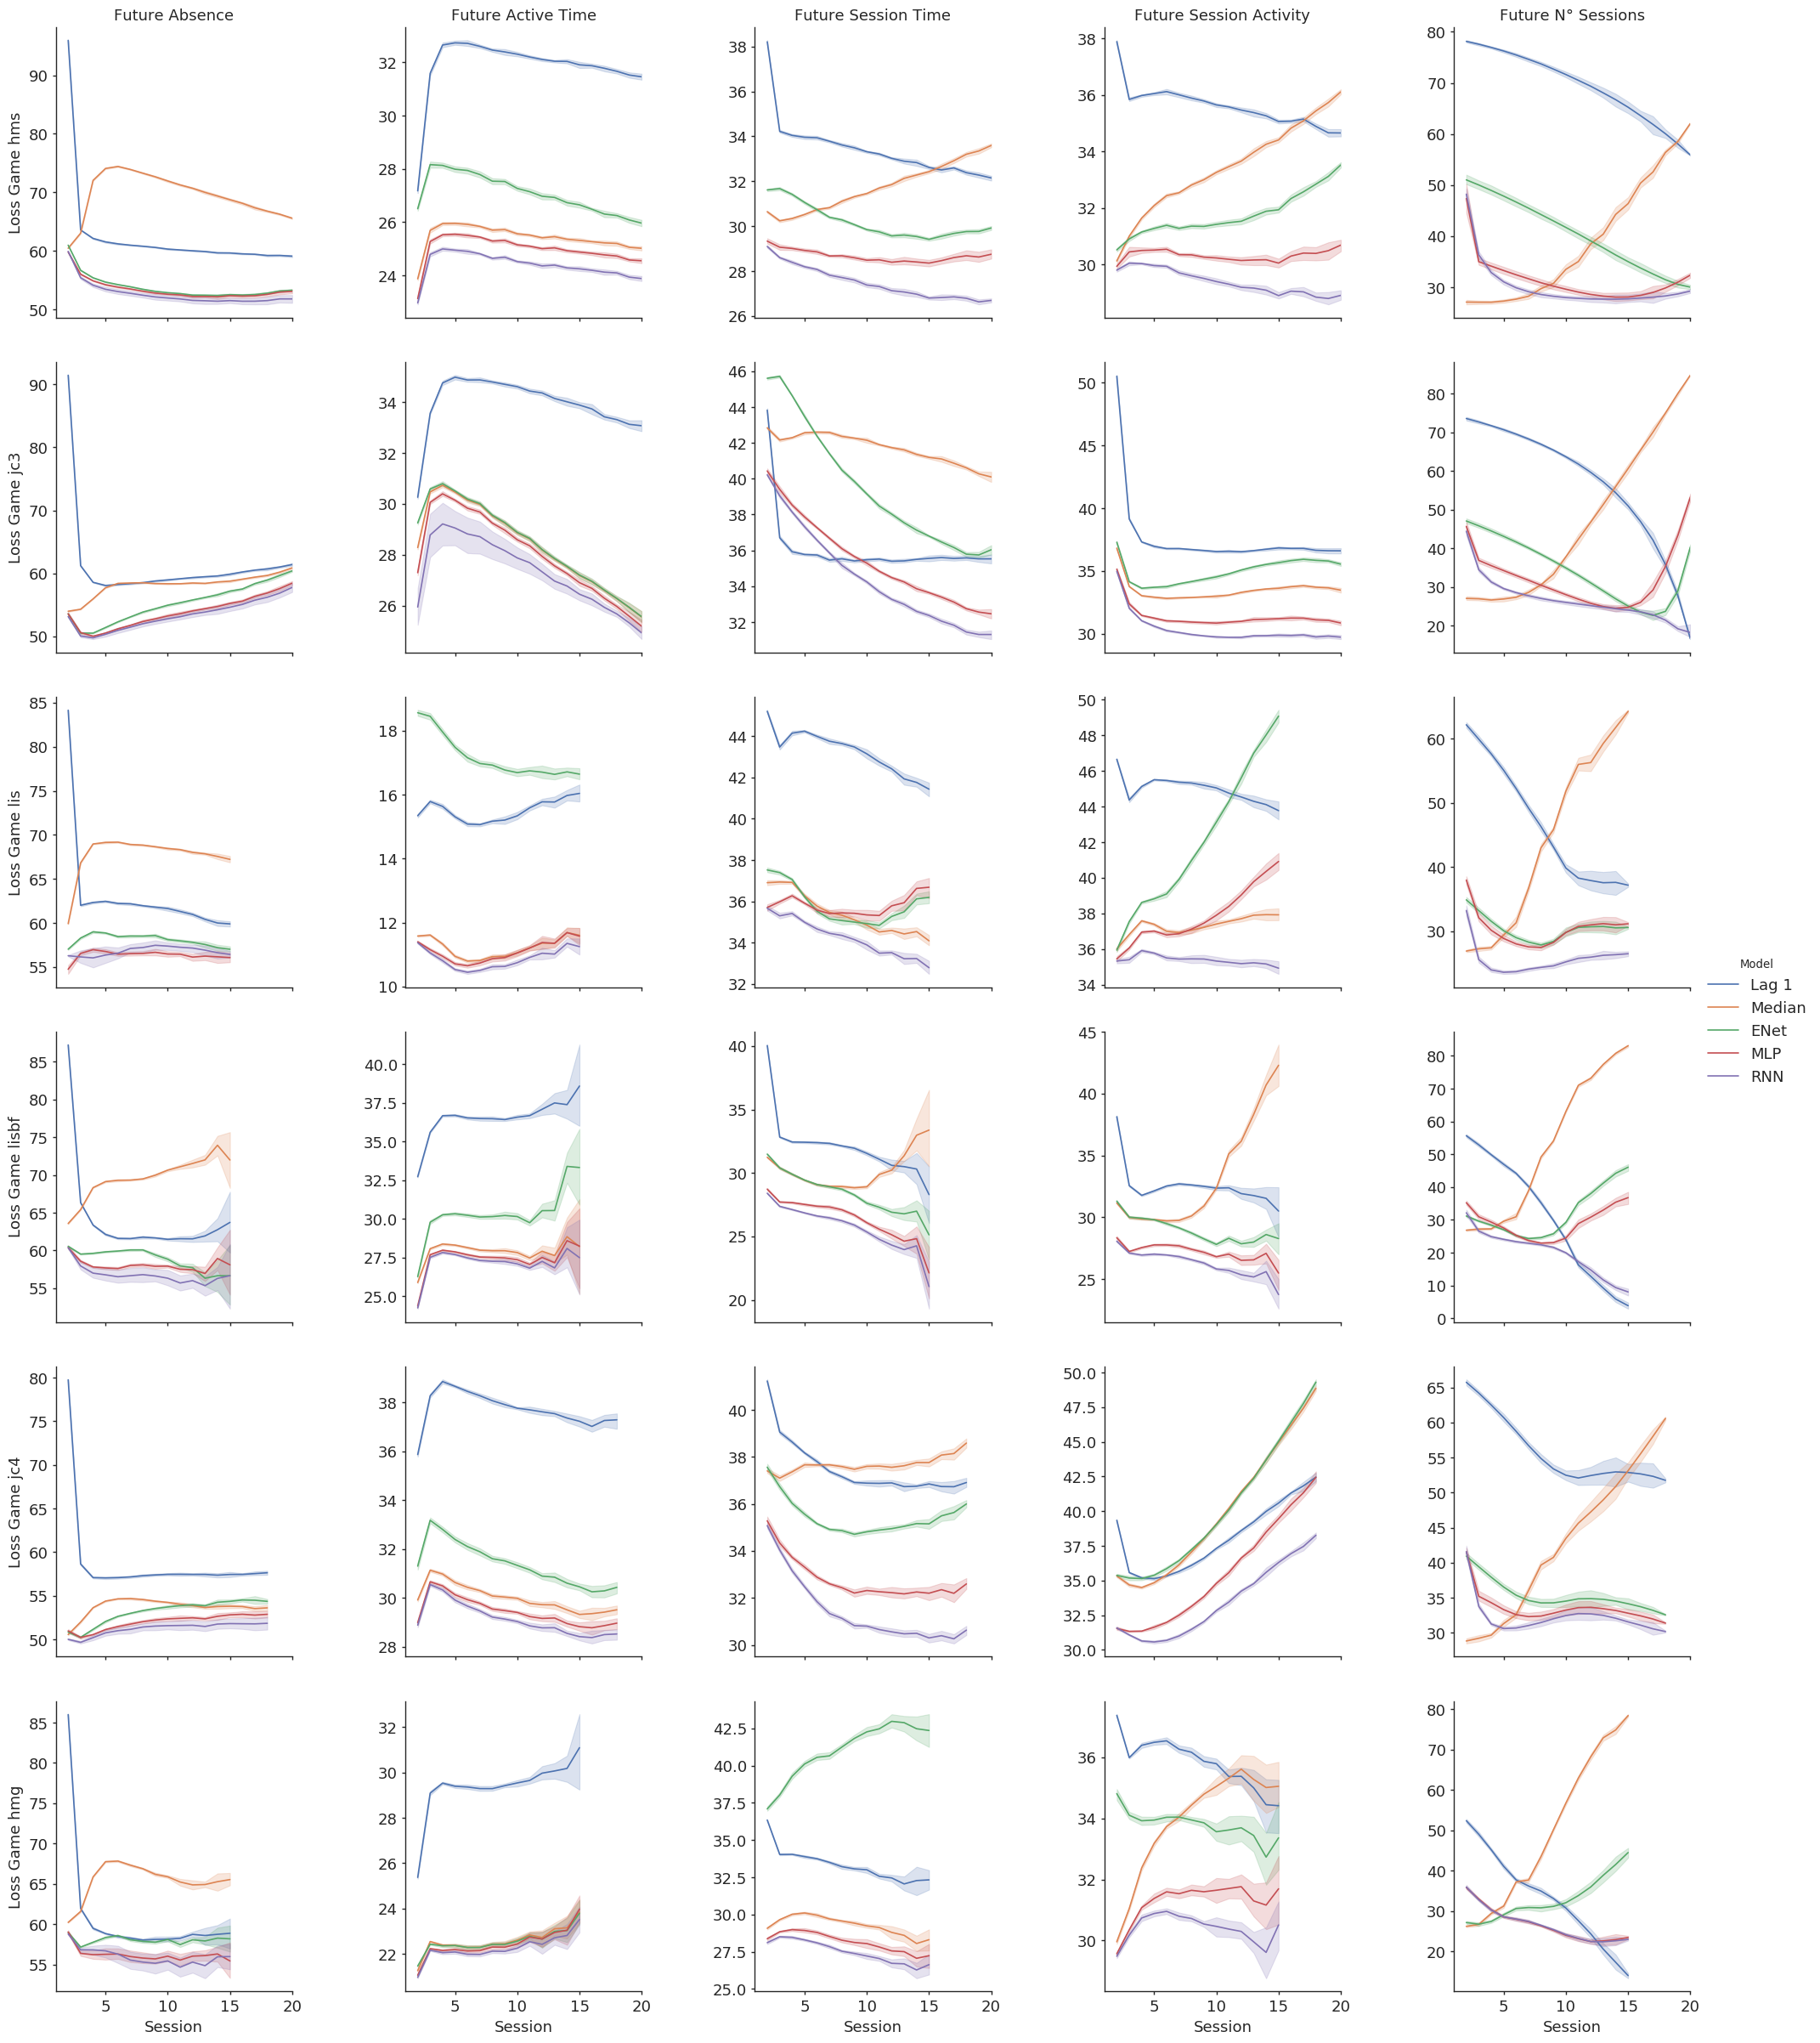

In [26]:
line_plots = sns.relplot(
    x='Session', 
    y='value', 
    hue='Model',
    col='target',
    row='context',
    kind='line',
    data=final_results,
    height=4,
    facet_kws={'sharey': False}
)
line_plots.set_titles('')

for column, target in enumerate([
    'Future Absence',    
    'Future Active Time',
    'Future Session Time',
    'Future Session Activity',
    'Future N° Sessions'
]):
    
    line_plots.axes[0, column].set_title(target)
    
for row, game in enumerate([
    'hms',
    'jc3',
    'lis',
    'lisbf',
    'jc4',
    'hmg'
]):
    line_plots.axes[row, 0].set_ylabel(f'Loss Game {game}')

plt.xlim(1, 20)
plt.show()

# Statistical Analysis: Linear Mixed Model

# Frequentist

In [6]:
vcf = {'Session': '0 + C(Session)', 'context': '0 + C(context)', 'fold_n': '0 + C(fold_n)'}
final_results['group'] = 1
collapsed_target['group'] =1

contrasts = np.array(
    [
        [0, 0, 1, 0, -1], # lag 1 - median
        [0, -1, 0, 0, 1], # enet - median
        [0, 1, 0, -1, 0], # enet - mlp
    ]
)

### Collapsed over Target

In [7]:
model = sm.MixedLM.from_formula(
    "value ~ C(Model, Treatment(reference='RNN'))", 
    groups='group',                                                    
    vc_formula=vcf, 
    re_formula='0', 
    data=collapsed_target
)                                                   
result = model.fit()
display(result.summary())

c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                        MixedLM           Dependent Variable:           value      
No. Observations:             4850              Method:                       REML       
No. Groups:                   1                 Scale:                        7.5895     
Min. group size:              4850              Log-Likelihood:               -11844.0091
Max. group size:              4850              Converged:                    No         
Mean group size:              4850.0                                                     
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      33.129    0.793 41.799 0.000 31.575 34.682
C(Model, Treatment(reference='RNN'))[T.ENet]    4.189    0.125 33.491 0.000  3.944  4.435
C(Model, Treatment(reference='RNN'))[T.Lag 1]  10.010    0.125 80.023 0.000  9.765 10.255
C(Model, Treatment(reference='RNN'))[T.MLP]     1.411    0.125 11.280 0.000  1.166  1.656
C(Model, Treatment(reference='RNN'))[T.Median]  7.482    0.125 59.813 0.000  7.237  7.727
Session Var                                     0.641                                    
context Var                                     3.518    2.945                           
fold_n Var                                      0.000                                    
=========================================================================================

"""

### Standardized Effect Sizes

In [8]:
residuals_df = pd.DataFrame(
    {
        'Residuals': result.resid,
        'Model': collapsed_target['Model'].values
    }
)

n = len(residuals_df[residuals_df['Model'] == 'RNN']['Residuals'])
var_1 = residuals_df[residuals_df['Model'] == 'RNN']['Residuals'].var()

std_effect_sizes = pd.DataFrame(
    columns=[
        'Model',
        'Coeff',
        "Cohen's d"
    ]
)
for index, model in enumerate(["ENet", "Lag 1", "MLP", "Median"], 1):

    var_2 = residuals_df[residuals_df['Model'] == model]['Residuals'].var()
    beta = result.params[index]
    cd = compute_cd_from_regression(
        beta=beta,
        var_1=var_1,
        var_2=var_2,
        n_1=n,
        n_2=n
    )
    std_effect_sizes.loc[index - 1] = [
        model,
        beta,
        cd
    ]
    
std_effect_sizes

,Model,Coeff,Cohen's d
0,ENet,4.189475,2.885152
1,Lag 1,10.010298,3.530274
2,MLP,1.410998,1.176523
3,Median,7.482169,2.391272


### Post Hoc

In [9]:
summary_post_hoc = result.t_test(contrasts).summary()
results_as_html = summary_post_hoc.as_html()
summary_post_hoc = pd.read_html(results_as_html, header=0, index_col=0)[0]
summary_post_hoc = summary_post_hoc.reset_index()
summary_post_hoc = summary_post_hoc.rename(
    {
        'index': 'Contrast'
    },
    axis=1
)
summary_post_hoc['Contrast'] = summary_post_hoc['Contrast'].map(
    {
        'c0': 'Lag 1 - Median',
        'c1': 'Median - ENet',
        'c2': 'ENet - MLP'
    }
)
display(summary_post_hoc)

,Contrast,coef,std err,z,P>|z|,[0.025,0.975]
0,Lag 1 - Median,2.5281,0.125,20.210,0.0,2.283,2.773
1,Median - ENet,3.2927,0.125,26.322,0.0,3.048,3.538
2,ENet - MLP,2.7785,0.125,22.211,0.0,2.533,3.024


### LMM non-collapsed over target

In [10]:
for target in final_results['target'].unique():
    
    print(target)
    
    data = final_results[final_results['target'] == target]
    model = sm.MixedLM.from_formula(
        "value ~ C(Model, Treatment(reference='RNN') )", 
        groups='fold_n',                                                    
        vc_formula=vcf, 
        re_formula='0', 
        data=data
    )                                                   
    result = model.fit()
    residuals_df = pd.DataFrame(
        {
            'Residuals': result.resid,
            'Model': collapsed_target['Model'].values
        }
    )
    
    n = len(residuals_df[residuals_df['Model'] == 'RNN']['Residuals'])
    var_1 = residuals_df[residuals_df['Model'] == 'RNN']['Residuals'].var()

    std_effect_sizes = pd.DataFrame(
        columns=[
            'Model',
            'Coeff',
            "Cohen's d"
        ]
    )
    for index, model in enumerate(["ENet", "Lag 1", "MLP", "Median"], 1):

        var_2 = residuals_df[residuals_df['Model'] == model]['Residuals'].var()
        beta = result.params[index]
        cd = compute_cd_from_regression(
            beta=beta,
            var_1=var_1,
            var_2=var_2,
            n_1=n,
            n_2=n
        )
        std_effect_sizes.loc[index - 1] = [
            model,
            beta,
            cd
        ]
    
    summary_post_hoc = result.t_test(contrasts).summary()
    results_as_html = summary_post_hoc.as_html()
    summary_post_hoc = pd.read_html(results_as_html, header=0, index_col=0)[0]
    summary_post_hoc = summary_post_hoc.reset_index()
    summary_post_hoc = summary_post_hoc.rename(
        {
            'index': 'Contrast'
        },
        axis=1
    )
    summary_post_hoc['Contrast'] = summary_post_hoc['Contrast'].map(
        {
            'c0': 'Lag 1 - Median',
            'c1': 'Median - ENet',
            'c2': 'ENet - MLP'
        }
    )
    print('Regression Results')
    display(result.summary())
    print('Standardized Effect Size')
    display(std_effect_sizes)
    print('Post Hoc')
    display(summary_post_hoc)

Future Absence


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


Regression Results


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                       MixedLM            Dependent Variable:            value      
No. Observations:            4850               Method:                        REML       
No. Groups:                  10                 Scale:                         16.2061    
Min. group size:             485                Log-Likelihood:                -13831.6194
Max. group size:             485                Converged:                     Yes        
Mean group size:             485.0                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      54.466    0.377 144.316 0.000 53.726 55.206
C(Model, Treatment(reference='RNN'))[T.ENet]    1.710    0.183   9.353 0.000  1.351  2.068
C(Model, Treatment(reference='RNN'))[T.Lag 1]   7.405    0.183  40.509 0.000  7.047  7.763
C(Model, Treatment(reference='RNN'))[T.MLP]     0.533    0.183   2.915 0.004  0.175  0.891
C(Model, Treatment(reference='RNN'))[T.Median]  9.471    0.183  51.814 0.000  9.113  9.830
Session Var                                     1.089    0.044                            
context Var                                     6.720    0.300                            
fold_n Var                                      0.076                                     
==========================================================================================

"""

Standardized Effect Size


,Model,Coeff,Cohen's d
0,ENet,1.709696,0.432517
1,Lag 1,7.404876,1.875552
2,MLP,0.532882,0.135975
3,Median,9.471400,2.380430


Post Hoc


,Contrast,coef,std err,z,P>|z|,[0.025,0.975]
0,Lag 1 - Median,-2.0665,0.183,-11.305,0.0,-2.425,-1.708
1,Median - ENet,7.7617,0.183,42.461,0.0,7.403,8.120
2,ENet - MLP,1.1768,0.183,6.438,0.0,0.819,1.535


Future Active Time


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Regression Results


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                        MixedLM            Dependent Variable:            value     
No. Observations:             4850               Method:                        REML      
No. Groups:                   10                 Scale:                         1.8361    
Min. group size:              485                Log-Likelihood:                -8752.9390
Max. group size:              485                Converged:                     Yes       
Mean group size:              485.0                                                       
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      23.361    0.805  29.019 0.000 21.784 24.939
C(Model, Treatment(reference='RNN'))[T.ENet]    2.557    0.062  41.551 0.000  2.436  2.677
C(Model, Treatment(reference='RNN'))[T.Lag 1]   7.324    0.062 119.028 0.000  7.203  7.444
C(Model, Treatment(reference='RNN'))[T.MLP]     0.415    0.062   6.739 0.000  0.294  0.535
C(Model, Treatment(reference='RNN'))[T.Median]  0.770    0.062  12.515 0.000  0.649  0.891
Session Var                                     0.429    0.043                            
context Var                                    38.581    4.893                            
fold_n Var                                      0.008                                     
==========================================================================================

"""

Standardized Effect Size


,Model,Coeff,Cohen's d
0,ENet,2.556610,1.944609
1,Lag 1,7.323696,5.481696
2,MLP,0.414642,0.311821
3,Median,0.770013,0.588668


Post Hoc


,Contrast,coef,std err,z,P>|z|,[0.025,0.975]
0,Lag 1 - Median,6.5537,0.062,106.513,0.0,6.433,6.674
1,Median - ENet,-1.7866,0.062,-29.037,0.0,-1.907,-1.666
2,ENet - MLP,2.1420,0.062,34.812,0.0,2.021,2.263


Future Session Time


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood

Regression Results


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                        MixedLM           Dependent Variable:           value      
No. Observations:             4850              Method:                       REML       
No. Groups:                   10                Scale:                        6.3489     
Min. group size:              485               Log-Likelihood:               -11630.0289
Max. group size:              485               Converged:                    No         
Mean group size:              485.0                                                      
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      30.026    0.471 63.693 0.000 29.102 30.950
C(Model, Treatment(reference='RNN'))[T.ENet]    4.814    0.114 42.076 0.000  4.590  5.038
C(Model, Treatment(reference='RNN'))[T.Lag 1]   5.621    0.114 49.132 0.000  5.397  5.846
C(Model, Treatment(reference='RNN'))[T.MLP]     1.089    0.114  9.515 0.000  0.864  1.313
C(Model, Treatment(reference='RNN'))[T.Median]  4.455    0.114 38.936 0.000  4.231  4.679
Session Var                                     0.645    0.039                           
context Var                                    12.136    0.884                           
fold_n Var                                      0.098                                    
=========================================================================================

"""

Standardized Effect Size


,Model,Coeff,Cohen's d
0,ENet,4.814045,1.935901
1,Lag 1,5.621350,2.259691
2,MLP,1.088591,0.442494
3,Median,4.454832,1.797093


Post Hoc


,Contrast,coef,std err,z,P>|z|,[0.025,0.975]
0,Lag 1 - Median,1.1665,0.114,10.196,0.000,0.942,1.391
1,Median - ENet,-0.3592,0.114,-3.140,0.002,-0.583,-0.135
2,ENet - MLP,3.7255,0.114,32.561,0.000,3.501,3.950


Future Session Activity


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


Regression Results


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                        MixedLM           Dependent Variable:           value      
No. Observations:             4850              Method:                       REML       
No. Groups:                   10                Scale:                        5.5513     
Min. group size:              485               Log-Likelihood:               -11330.6021
Max. group size:              485               Converged:                    Yes        
Mean group size:              485.0                                                      
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      31.042    0.442 70.241 0.000 30.176 31.908
C(Model, Treatment(reference='RNN'))[T.ENet]    4.421    0.107 41.319 0.000  4.211  4.630
C(Model, Treatment(reference='RNN'))[T.Lag 1]   6.529    0.107 61.025 0.000  6.319  6.738
C(Model, Treatment(reference='RNN'))[T.MLP]     1.365    0.107 12.762 0.000  1.156  1.575
C(Model, Treatment(reference='RNN'))[T.Median]  4.373    0.107 40.879 0.000  4.164  4.583
Session Var                                     0.818    0.051                           
context Var                                    11.098    0.816                           
fold_n Var                                      0.001                                    
=========================================================================================

"""

Standardized Effect Size


,Model,Coeff,Cohen's d
0,ENet,4.420581,1.910712
1,Lag 1,6.528772,2.812499
2,MLP,1.365329,0.594640
3,Median,4.373408,1.894837


Post Hoc


,Contrast,coef,std err,z,P>|z|,[0.025,0.975]
0,Lag 1 - Median,2.1554,0.107,20.146,0.000,1.946,2.365
1,Median - ENet,-0.0472,0.107,-0.441,0.659,-0.257,0.163
2,ENet - MLP,3.0553,0.107,28.558,0.000,2.846,3.265


Future N° Sessions


c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
c:\users\penthotal\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood

Regression Results


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                       MixedLM            Dependent Variable:            value      
No. Observations:            4850               Method:                        REML       
No. Groups:                  10                 Scale:                         131.9289   
Min. group size:             485                Log-Likelihood:                -18841.4287
Max. group size:             485                Converged:                     No         
Mean group size:             485.0                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       26.771    3.596  7.445 0.000 19.724 33.819
C(Model, Treatment(reference='RNN'))[T.ENet]     7.446    0.522 14.277 0.000  6.424  8.469
C(Model, Treatment(reference='RNN'))[T.Lag 1]   23.173    0.522 44.430 0.000 22.151 24.195
C(Model, Treatment(reference='RNN'))[T.MLP]      3.654    0.522  7.005 0.000  2.631  4.676
C(Model, Treatment(reference='RNN'))[T.Median]  18.341    0.522 35.166 0.000 17.319 19.363
Session Var                                      0.270    0.158                           
context Var                                     58.705                                    
fold_n Var                                     118.132                                    
==========================================================================================

"""

Standardized Effect Size


,Model,Coeff,Cohen's d
0,ENet,7.446443,0.647009
1,Lag 1,23.172795,2.032663
2,MLP,3.653546,0.319624
3,Median,18.341190,1.606723


Post Hoc


,Contrast,coef,std err,z,P>|z|,[0.025,0.975]
0,Lag 1 - Median,4.8316,0.522,9.264,0.0,3.809,5.854
1,Median - ENet,10.8947,0.522,20.889,0.0,9.873,11.917
2,ENet - MLP,3.7929,0.522,7.272,0.0,2.771,4.815


# Bayesian

In order to attenuate the impact of extreme results we use a Student-T distribution for the model's likelyhood. Differently from the the analysis carried out with statsmodels (see above) we do not use a treatment coding of the indipendent variable but a simple coding with reference level given by the grand-mean of the dependent variable.

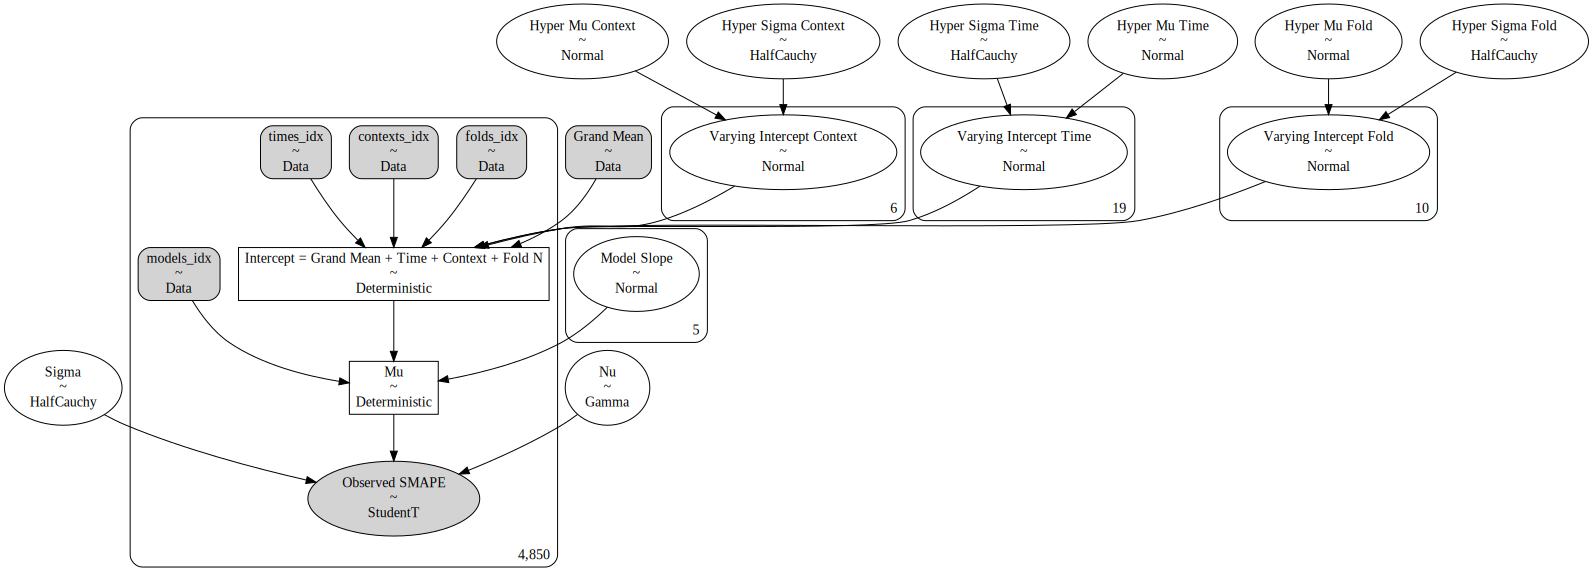

Finished [100%]: Average Loss = 12,143


Future Absence


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Context[0],-1.265,0.080,-1.401,-1.108,0.002,0.002,1024.0,923.0,NaN
Varying Intercept Context[1],-0.769,0.080,-0.924,-0.617,0.003,0.002,941.0,975.0,NaN
Varying Intercept Context[2],2.555,0.062,2.436,2.664,0.002,0.001,961.0,912.0,NaN
Varying Intercept Context[3],3.540,0.082,3.377,3.683,0.003,0.002,991.0,872.0,NaN
Varying Intercept Context[4],-2.603,0.058,-2.714,-2.491,0.002,0.001,1013.0,1060.0,NaN
Varying Intercept Context[5],1.599,0.086,1.444,1.767,0.003,0.002,1016.0,982.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Time[0],-0.407,0.200,-0.760,-0.005,0.006,0.004,992.0,1069.0,NaN
Varying Intercept Time[1],-0.260,0.130,-0.512,-0.035,0.004,0.003,1018.0,1025.0,NaN
Varying Intercept Time[2],-0.317,0.110,-0.521,-0.116,0.003,0.002,1029.0,939.0,NaN
Varying Intercept Time[3],-0.273,0.111,-0.480,-0.072,0.004,0.003,987.0,820.0,NaN
Varying Intercept Time[4],-0.339,0.103,-0.531,-0.153,0.003,0.002,893.0,975.0,NaN
Varying Intercept Time[5],-0.309,0.101,-0.495,-0.121,0.003,0.002,999.0,1024.0,NaN
Varying Intercept Time[6],-0.312,0.100,-0.516,-0.145,0.003,0.002,932.0,995.0,NaN
Varying Intercept Time[7],-0.320,0.095,-0.492,-0.138,0.003,0.002,992.0,878.0,NaN
Varying Intercept Time[8],-0.317,0.099,-0.501,-0.130,0.003,0.002,953.0,746.0,NaN
Varying Intercept Time[9],-0.428,0.099,-0.616,-0.259,0.003,0.002,1038.0,831.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Fold[0],-0.339,0.088,-0.497,-0.165,0.003,0.002,952.0,941.0,NaN
Varying Intercept Fold[1],-0.300,0.088,-0.457,-0.127,0.003,0.002,799.0,820.0,NaN
Varying Intercept Fold[2],-0.348,0.086,-0.519,-0.191,0.003,0.002,993.0,952.0,NaN
Varying Intercept Fold[3],0.173,0.088,0.031,0.352,0.003,0.002,1086.0,841.0,NaN
Varying Intercept Fold[4],0.131,0.089,-0.056,0.278,0.003,0.002,952.0,886.0,NaN
Varying Intercept Fold[5],0.178,0.085,0.031,0.346,0.003,0.002,993.0,812.0,NaN
Varying Intercept Fold[6],-0.044,0.086,-0.210,0.107,0.003,0.002,901.0,884.0,NaN
Varying Intercept Fold[7],0.057,0.088,-0.108,0.229,0.003,0.002,945.0,942.0,NaN
Varying Intercept Fold[8],-0.238,0.087,-0.394,-0.070,0.003,0.002,894.0,923.0,NaN
Varying Intercept Fold[9],-0.266,0.085,-0.422,-0.104,0.003,0.002,778.0,981.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Model Slope[0],1.931,0.063,1.815,2.049,0.002,0.001,1014.0,915.0,NaN
Model Slope[1],7.322,0.111,7.095,7.514,0.003,0.002,1038.0,850.0,NaN
Model Slope[2],-1.932,0.064,-2.055,-1.816,0.002,0.001,1106.0,918.0,NaN
Model Slope[3],-3.372,0.053,-3.477,-3.273,0.002,0.001,1124.0,1047.0,NaN
Model Slope[4],-3.860,0.067,-3.980,-3.730,0.002,0.002,866.0,956.0,NaN


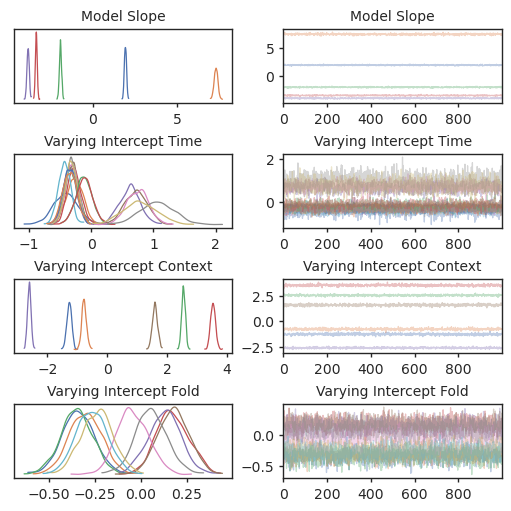

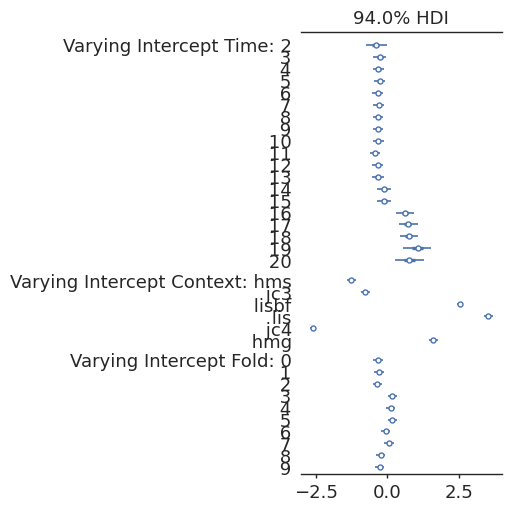

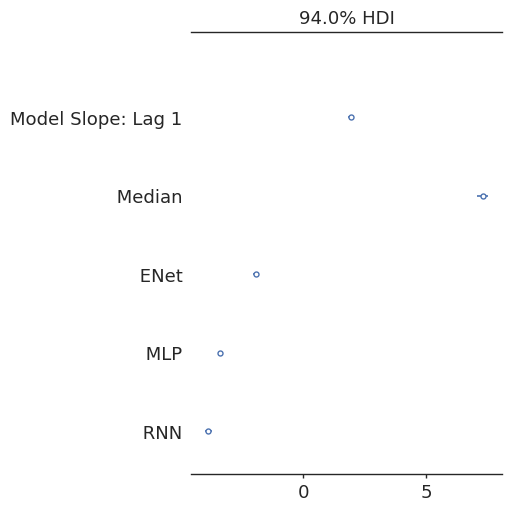

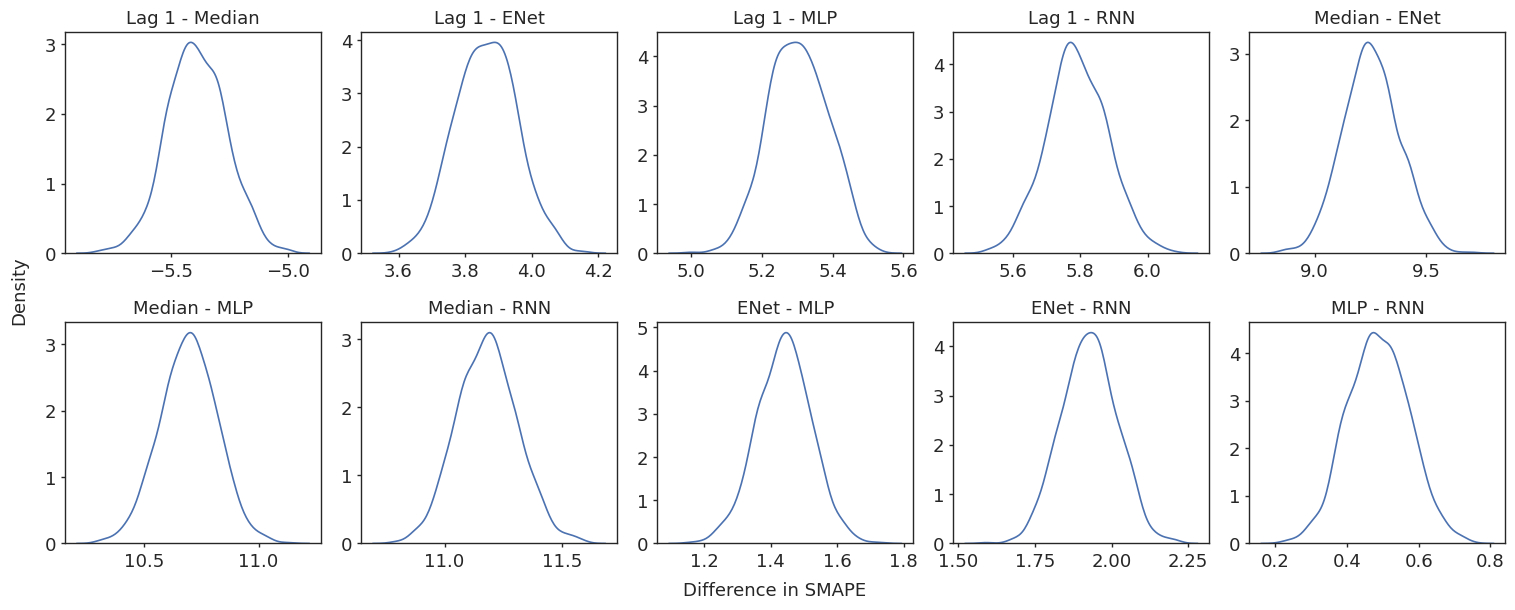

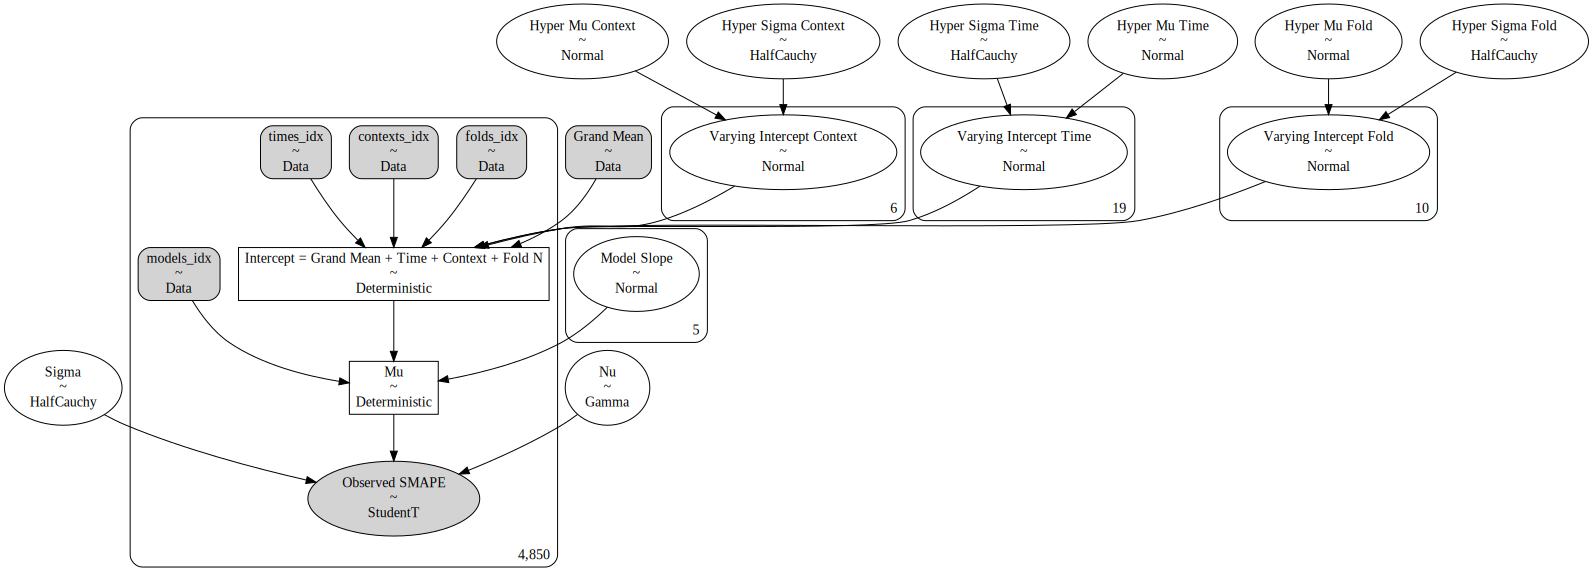

Finished [100%]: Average Loss = 7,524.1


Future Active Time


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Context[0],2.829,0.018,2.794,2.859,0.001,0.000,888.0,1016.0,NaN
Varying Intercept Context[1],5.008,0.030,4.949,5.061,0.001,0.001,1014.0,912.0,NaN
Varying Intercept Context[2],-11.501,0.036,-11.563,-11.431,0.001,0.001,961.0,952.0,NaN
Varying Intercept Context[3],5.251,0.029,5.203,5.308,0.001,0.001,1088.0,883.0,NaN
Varying Intercept Context[4],7.364,0.026,7.314,7.410,0.001,0.001,874.0,952.0,NaN
Varying Intercept Context[5],-0.337,0.028,-0.392,-0.287,0.001,0.001,1020.0,952.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Time[0],-0.991,0.081,-1.158,-0.855,0.003,0.002,900.0,824.0,NaN
Varying Intercept Time[1],0.305,0.047,0.220,0.397,0.002,0.001,932.0,883.0,NaN
Varying Intercept Time[2],0.387,0.040,0.311,0.460,0.001,0.001,1033.0,940.0,NaN
Varying Intercept Time[3],0.298,0.038,0.224,0.367,0.001,0.001,924.0,865.0,NaN
Varying Intercept Time[4],0.182,0.038,0.109,0.252,0.001,0.001,984.0,909.0,NaN
Varying Intercept Time[5],0.093,0.037,0.025,0.160,0.001,0.001,966.0,910.0,NaN
Varying Intercept Time[6],0.017,0.037,-0.052,0.086,0.001,0.001,1080.0,874.0,NaN
Varying Intercept Time[7],0.007,0.036,-0.054,0.082,0.001,0.001,988.0,850.0,NaN
Varying Intercept Time[8],-0.052,0.039,-0.123,0.021,0.001,0.001,1255.0,1070.0,NaN
Varying Intercept Time[9],-0.134,0.045,-0.226,-0.057,0.001,0.001,991.0,849.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Fold[0],-0.077,0.022,-0.115,-0.035,0.001,0.001,910.0,979.0,NaN
Varying Intercept Fold[1],-0.074,0.021,-0.111,-0.037,0.001,0.001,843.0,746.0,NaN
Varying Intercept Fold[2],-0.071,0.021,-0.111,-0.032,0.001,0.000,1081.0,1025.0,NaN
Varying Intercept Fold[3],-0.061,0.022,-0.099,-0.021,0.001,0.000,1207.0,879.0,NaN
Varying Intercept Fold[4],-0.062,0.020,-0.098,-0.021,0.001,0.000,949.0,844.0,NaN
Varying Intercept Fold[5],-0.066,0.021,-0.105,-0.029,0.001,0.000,1124.0,941.0,NaN
Varying Intercept Fold[6],-0.065,0.021,-0.101,-0.024,0.001,0.000,1009.0,944.0,NaN
Varying Intercept Fold[7],-0.080,0.021,-0.123,-0.043,0.001,0.001,814.0,983.0,NaN
Varying Intercept Fold[8],-0.061,0.022,-0.102,-0.023,0.001,0.001,928.0,877.0,NaN
Varying Intercept Fold[9],-0.070,0.022,-0.110,-0.030,0.001,0.000,1066.0,979.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Model Slope[0],3.660,0.028,3.607,3.709,0.001,0.001,832.0,617.0,NaN
Model Slope[1],-3.257,0.022,-3.296,-3.214,0.001,0.001,895.0,786.0,NaN
Model Slope[2],-1.640,0.029,-1.694,-1.584,0.001,0.001,1035.0,983.0,NaN
Model Slope[3],-3.621,0.022,-3.659,-3.576,0.001,0.000,1018.0,843.0,NaN
Model Slope[4],-3.994,0.022,-4.037,-3.954,0.001,0.001,868.0,1024.0,NaN


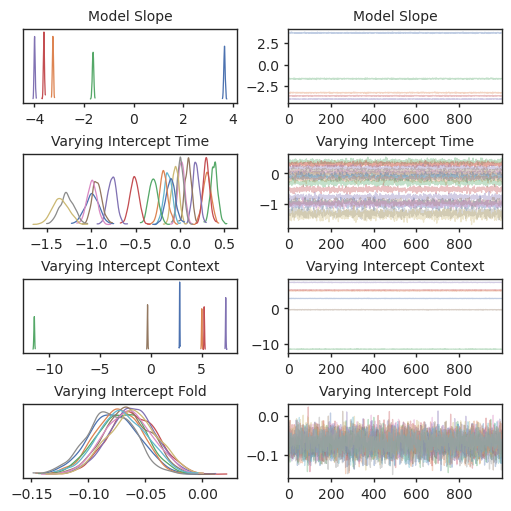

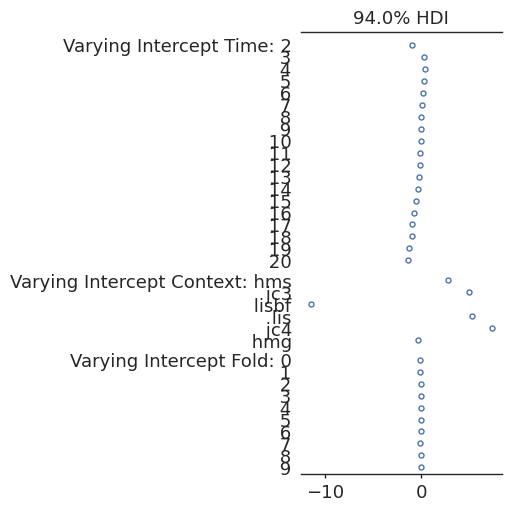

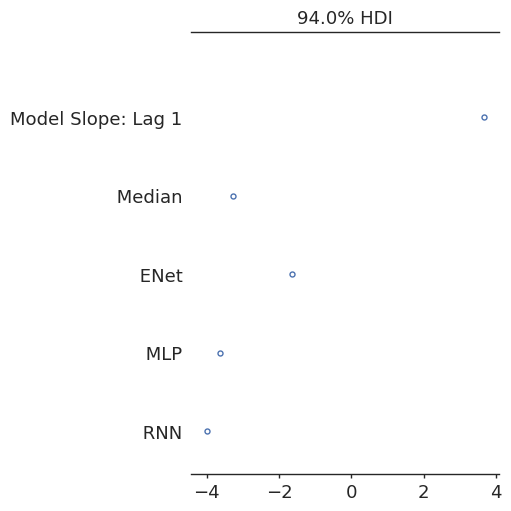

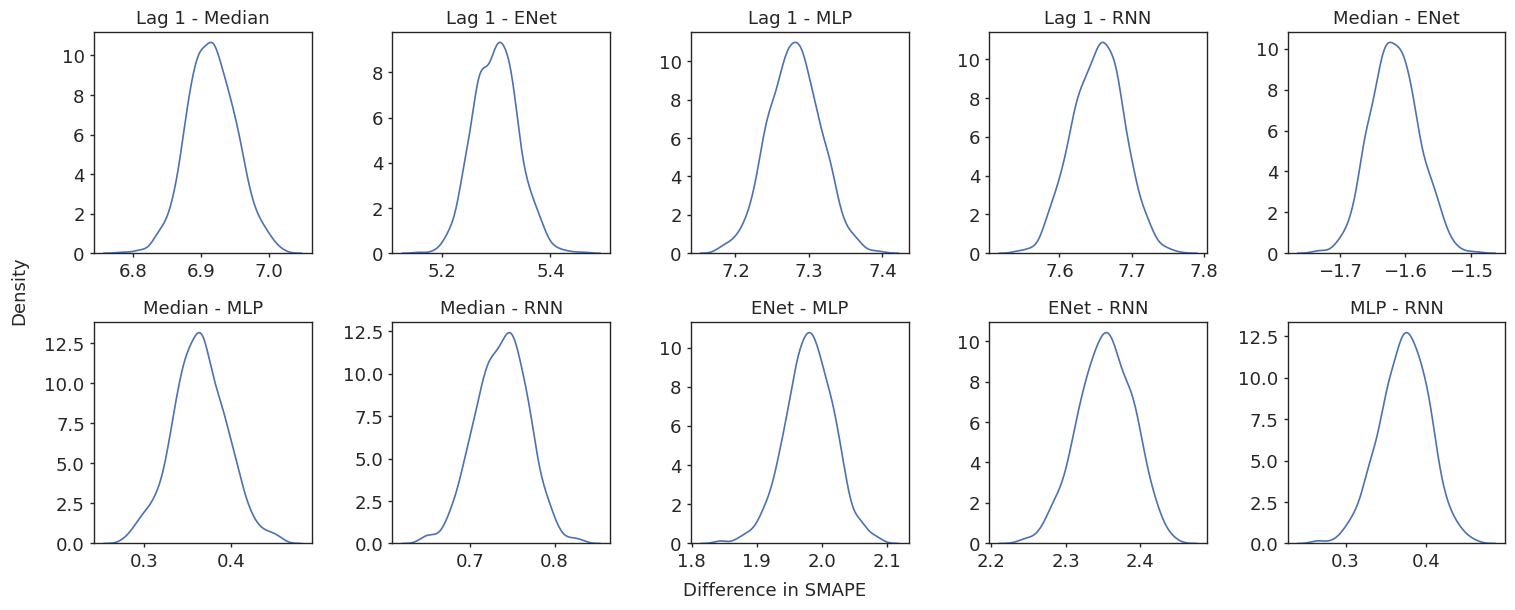

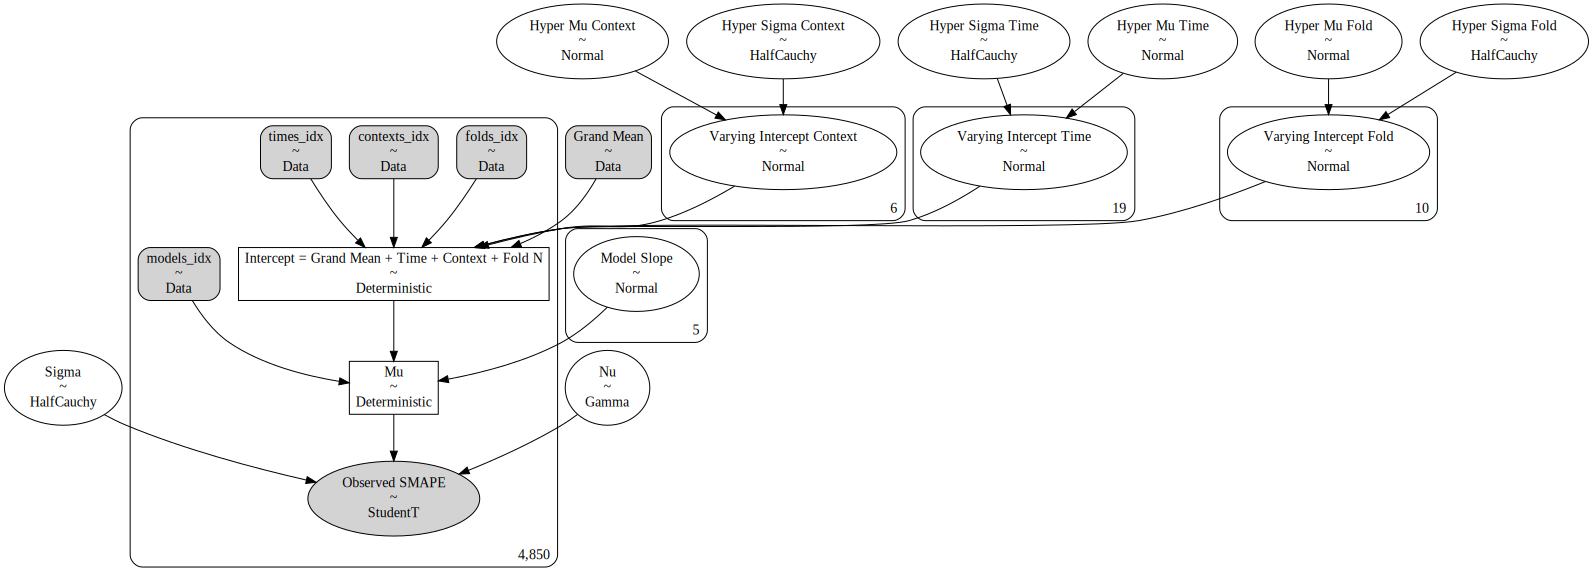

Finished [100%]: Average Loss = 10,362


Future Session Time


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Context[0],-2.554,0.027,-2.602,-2.501,0.001,0.001,874.0,735.0,NaN
Varying Intercept Context[1],5.217,0.082,5.060,5.367,0.002,0.002,1147.0,981.0,NaN
Varying Intercept Context[2],3.908,0.056,3.806,4.005,0.002,0.001,990.0,904.0,NaN
Varying Intercept Context[3],-4.442,0.039,-4.510,-4.369,0.001,0.001,1020.0,941.0,NaN
Varying Intercept Context[4],1.716,0.033,1.655,1.779,0.001,0.001,972.0,904.0,NaN
Varying Intercept Context[5],-2.881,0.041,-2.956,-2.803,0.001,0.001,914.0,988.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Time[0],1.944,0.126,1.713,2.182,0.004,0.003,898.0,982.0,NaN
Varying Intercept Time[1],0.932,0.062,0.815,1.046,0.002,0.001,942.0,1028.0,NaN
Varying Intercept Time[2],0.773,0.056,0.679,0.884,0.002,0.001,1083.0,1069.0,NaN
Varying Intercept Time[3],0.512,0.053,0.420,0.609,0.002,0.001,1004.0,899.0,NaN
Varying Intercept Time[4],0.279,0.053,0.174,0.371,0.002,0.001,902.0,907.0,NaN
Varying Intercept Time[5],0.031,0.056,-0.088,0.126,0.002,0.001,970.0,842.0,NaN
Varying Intercept Time[6],-0.180,0.055,-0.279,-0.073,0.002,0.001,924.0,945.0,NaN
Varying Intercept Time[7],-0.406,0.061,-0.527,-0.299,0.002,0.001,991.0,1015.0,NaN
Varying Intercept Time[8],-0.642,0.065,-0.771,-0.526,0.002,0.002,918.0,865.0,NaN
Varying Intercept Time[9],-0.862,0.067,-0.986,-0.740,0.002,0.001,997.0,1008.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Fold[0],-0.236,0.037,-0.303,-0.166,0.001,0.001,931.0,916.0,NaN
Varying Intercept Fold[1],-0.296,0.037,-0.370,-0.231,0.001,0.001,1047.0,917.0,NaN
Varying Intercept Fold[2],-0.309,0.040,-0.383,-0.239,0.001,0.001,899.0,936.0,NaN
Varying Intercept Fold[3],-0.264,0.038,-0.332,-0.186,0.001,0.001,997.0,873.0,NaN
Varying Intercept Fold[4],-0.239,0.040,-0.321,-0.173,0.001,0.001,943.0,893.0,NaN
Varying Intercept Fold[5],-0.260,0.036,-0.326,-0.190,0.001,0.001,886.0,906.0,NaN
Varying Intercept Fold[6],-0.269,0.038,-0.335,-0.197,0.001,0.001,961.0,1038.0,NaN
Varying Intercept Fold[7],-0.242,0.037,-0.307,-0.172,0.001,0.001,1030.0,901.0,NaN
Varying Intercept Fold[8],-0.313,0.038,-0.388,-0.244,0.001,0.001,833.0,869.0,NaN
Varying Intercept Fold[9],-0.303,0.039,-0.371,-0.226,0.001,0.001,957.0,906.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Model Slope[0],3.078,0.032,3.020,3.135,0.001,0.001,910.0,961.0,NaN
Model Slope[1],2.599,0.072,2.469,2.742,0.002,0.002,1020.0,959.0,NaN
Model Slope[2],0.053,0.038,-0.018,0.126,0.001,0.001,951.0,936.0,NaN
Model Slope[3],-1.787,0.033,-1.852,-1.729,0.001,0.001,964.0,976.0,NaN
Model Slope[4],-2.812,0.031,-2.871,-2.754,0.001,0.001,937.0,915.0,NaN


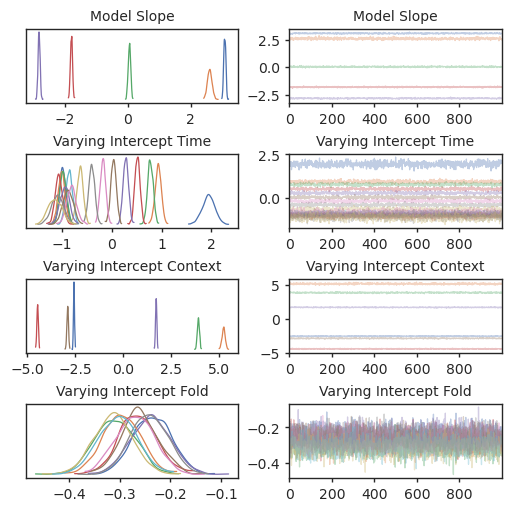

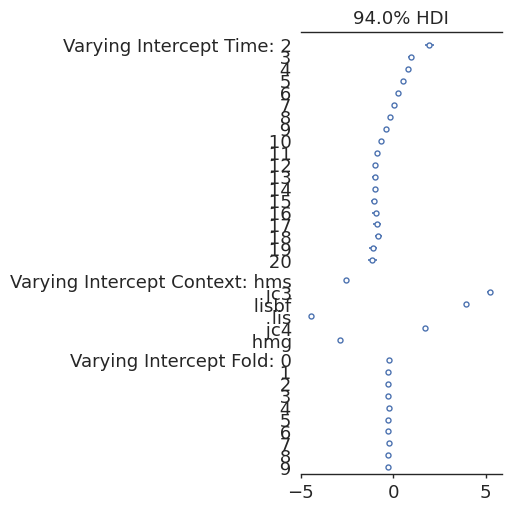

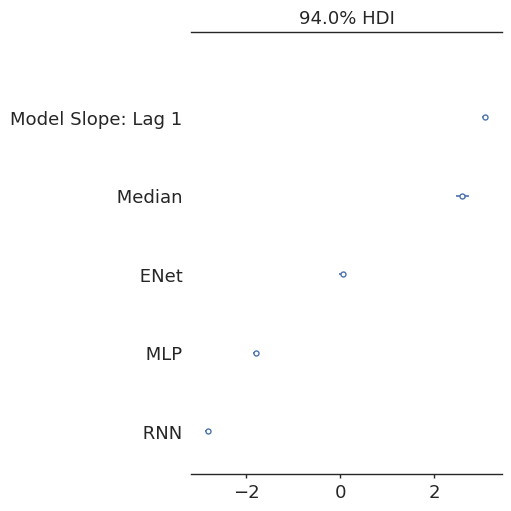

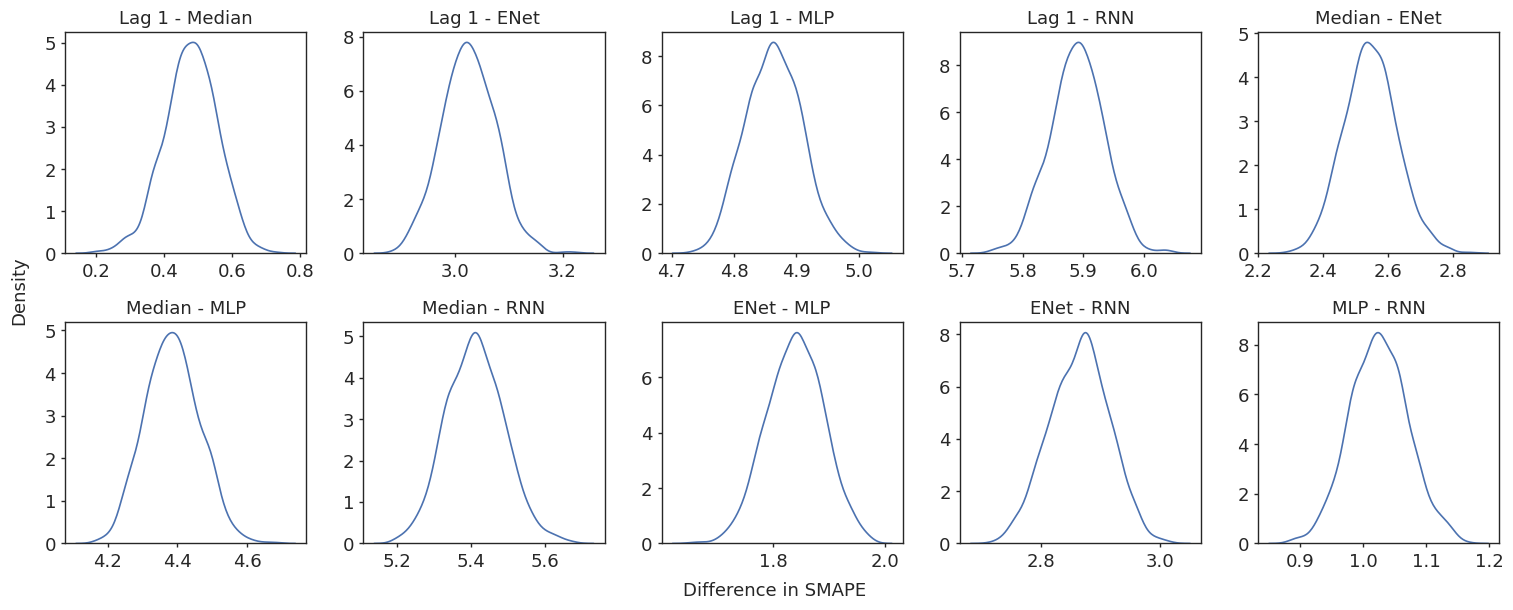

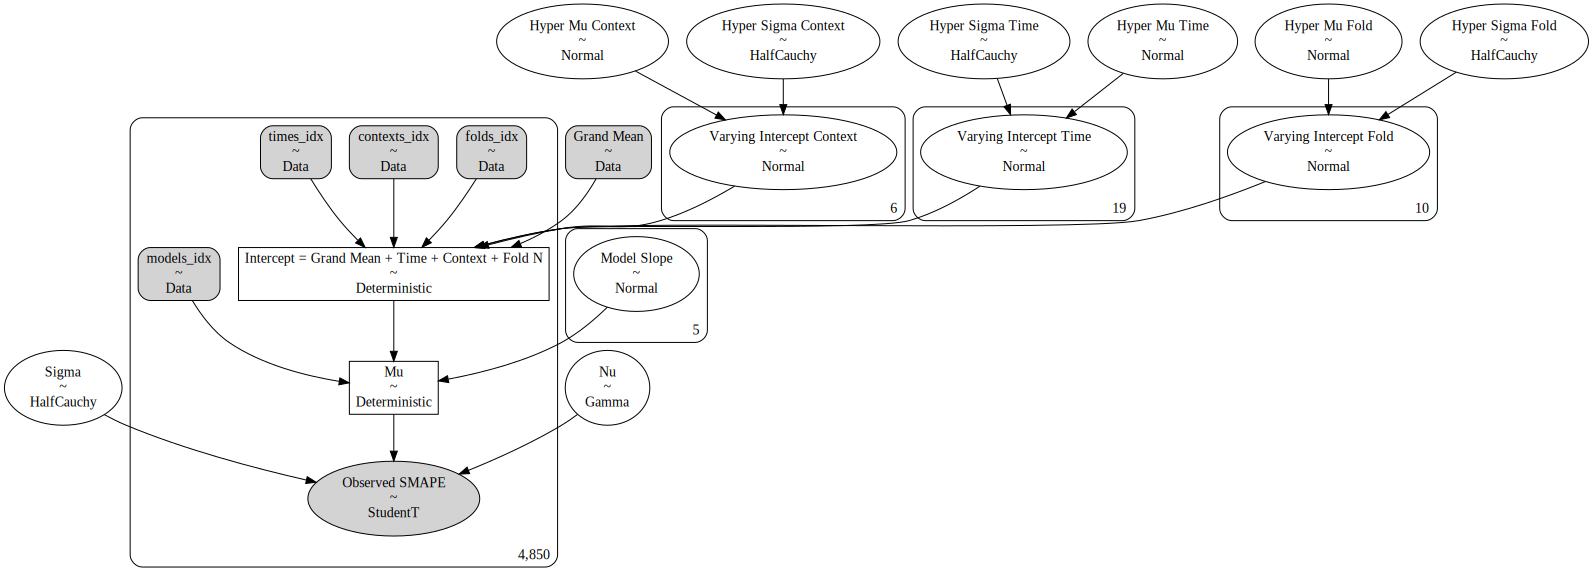

Finished [100%]: Average Loss = 10,087


Future Session Activity


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Context[0],-1.865,0.032,-1.927,-1.807,0.001,0.001,871.0,827.0,NaN
Varying Intercept Context[1],-0.833,0.030,-0.888,-0.775,0.001,0.001,945.0,981.0,NaN
Varying Intercept Context[2],4.508,0.060,4.402,4.622,0.002,0.001,1052.0,737.0,NaN
Varying Intercept Context[3],-4.799,0.041,-4.876,-4.723,0.001,0.001,980.0,1015.0,NaN
Varying Intercept Context[4],1.145,0.082,0.997,1.307,0.003,0.002,1017.0,943.0,NaN
Varying Intercept Context[5],-0.725,0.040,-0.802,-0.651,0.001,0.001,916.0,983.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Time[0],-0.046,0.078,-0.203,0.090,0.003,0.002,965.0,992.0,NaN
Varying Intercept Time[1],-0.215,0.055,-0.318,-0.111,0.002,0.001,952.0,848.0,NaN
Varying Intercept Time[2],-0.187,0.052,-0.288,-0.090,0.002,0.001,867.0,910.0,NaN
Varying Intercept Time[3],-0.142,0.046,-0.226,-0.053,0.002,0.001,928.0,644.0,NaN
Varying Intercept Time[4],-0.098,0.043,-0.179,-0.015,0.001,0.001,968.0,873.0,NaN
Varying Intercept Time[5],-0.052,0.048,-0.146,0.035,0.001,0.001,1050.0,909.0,NaN
Varying Intercept Time[6],-0.038,0.051,-0.132,0.062,0.002,0.001,949.0,1016.0,NaN
Varying Intercept Time[7],-0.056,0.054,-0.159,0.041,0.002,0.001,900.0,908.0,NaN
Varying Intercept Time[8],-0.121,0.054,-0.216,-0.011,0.002,0.001,956.0,1015.0,NaN
Varying Intercept Time[9],-0.159,0.060,-0.275,-0.053,0.002,0.001,934.0,941.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Fold[0],-0.097,0.041,-0.181,-0.029,0.001,0.001,985.0,1017.0,NaN
Varying Intercept Fold[1],-0.136,0.043,-0.214,-0.052,0.001,0.001,952.0,962.0,NaN
Varying Intercept Fold[2],-0.128,0.044,-0.200,-0.039,0.001,0.001,978.0,983.0,NaN
Varying Intercept Fold[3],-0.059,0.043,-0.135,0.025,0.001,0.001,990.0,843.0,NaN
Varying Intercept Fold[4],-0.052,0.043,-0.143,0.020,0.001,0.001,1016.0,647.0,NaN
Varying Intercept Fold[5],-0.088,0.040,-0.156,-0.013,0.001,0.001,732.0,789.0,NaN
Varying Intercept Fold[6],-0.092,0.044,-0.168,-0.006,0.002,0.001,834.0,936.0,NaN
Varying Intercept Fold[7],-0.014,0.043,-0.098,0.059,0.001,0.001,1015.0,823.0,NaN
Varying Intercept Fold[8],-0.168,0.044,-0.247,-0.084,0.001,0.001,1152.0,945.0,NaN
Varying Intercept Fold[9],-0.113,0.042,-0.187,-0.035,0.001,0.001,989.0,915.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Model Slope[0],3.442,0.037,3.363,3.502,0.001,0.001,968.0,985.0,NaN
Model Slope[1],0.429,0.047,0.336,0.510,0.002,0.001,858.0,886.0,NaN
Model Slope[2],0.577,0.045,0.489,0.659,0.001,0.001,1072.0,1024.0,NaN
Model Slope[3],-1.826,0.030,-1.881,-1.772,0.001,0.001,908.0,950.0,NaN
Model Slope[4],-2.937,0.034,-2.996,-2.873,0.001,0.001,918.0,823.0,NaN


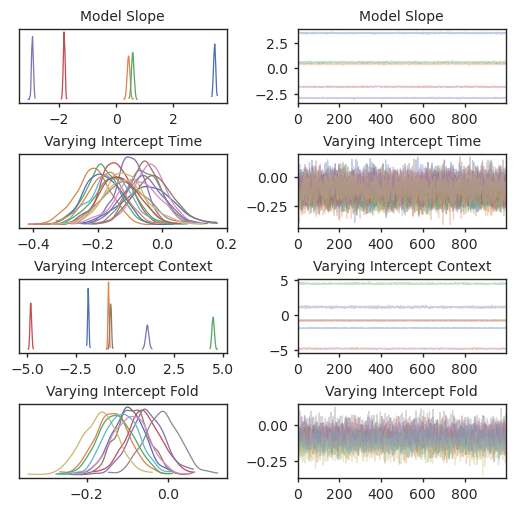

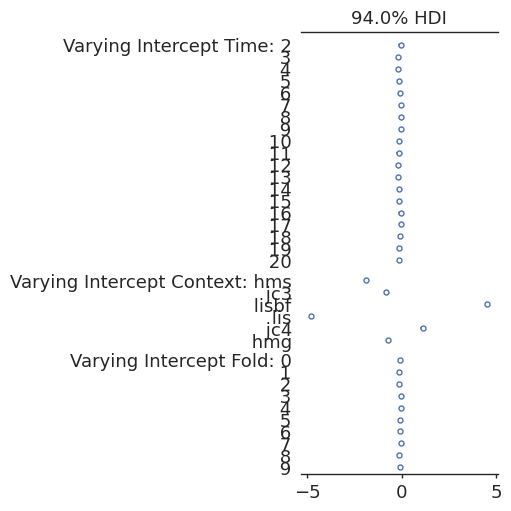

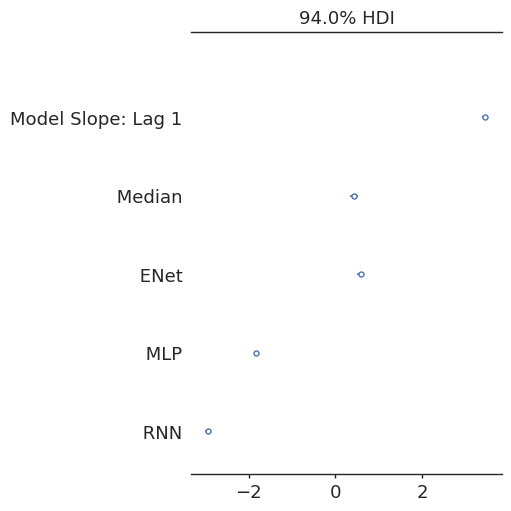

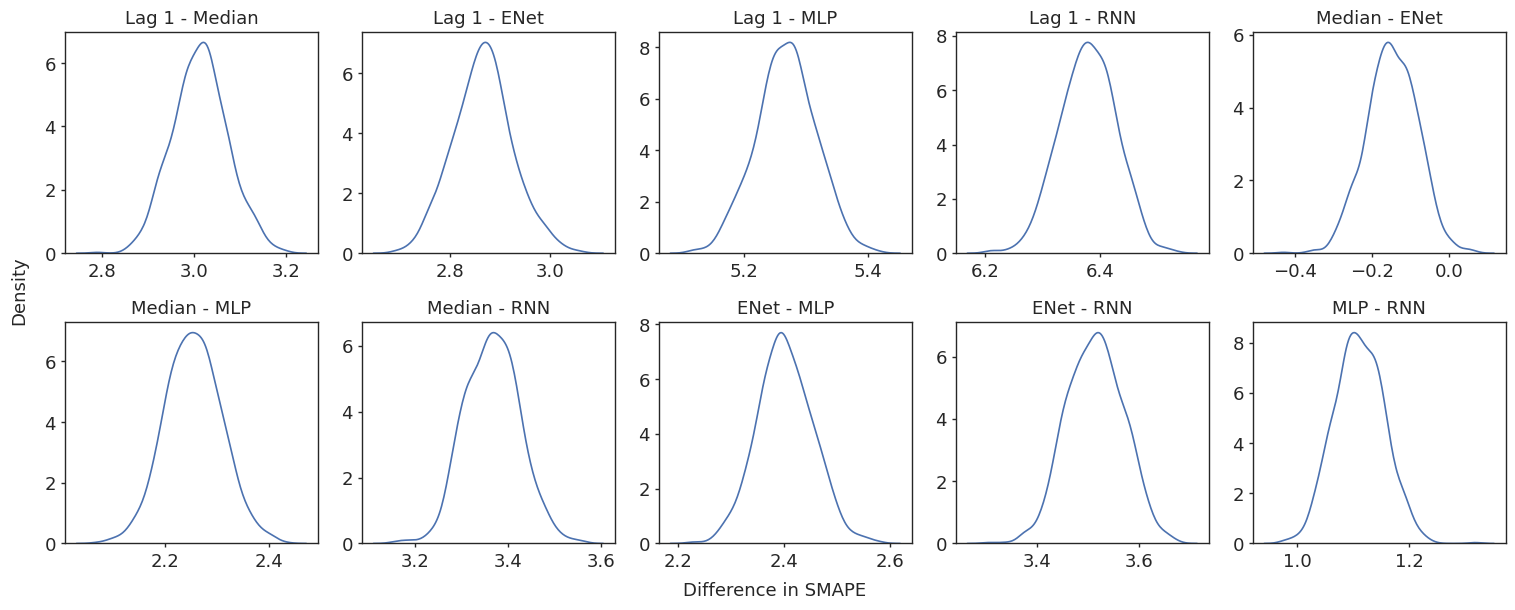

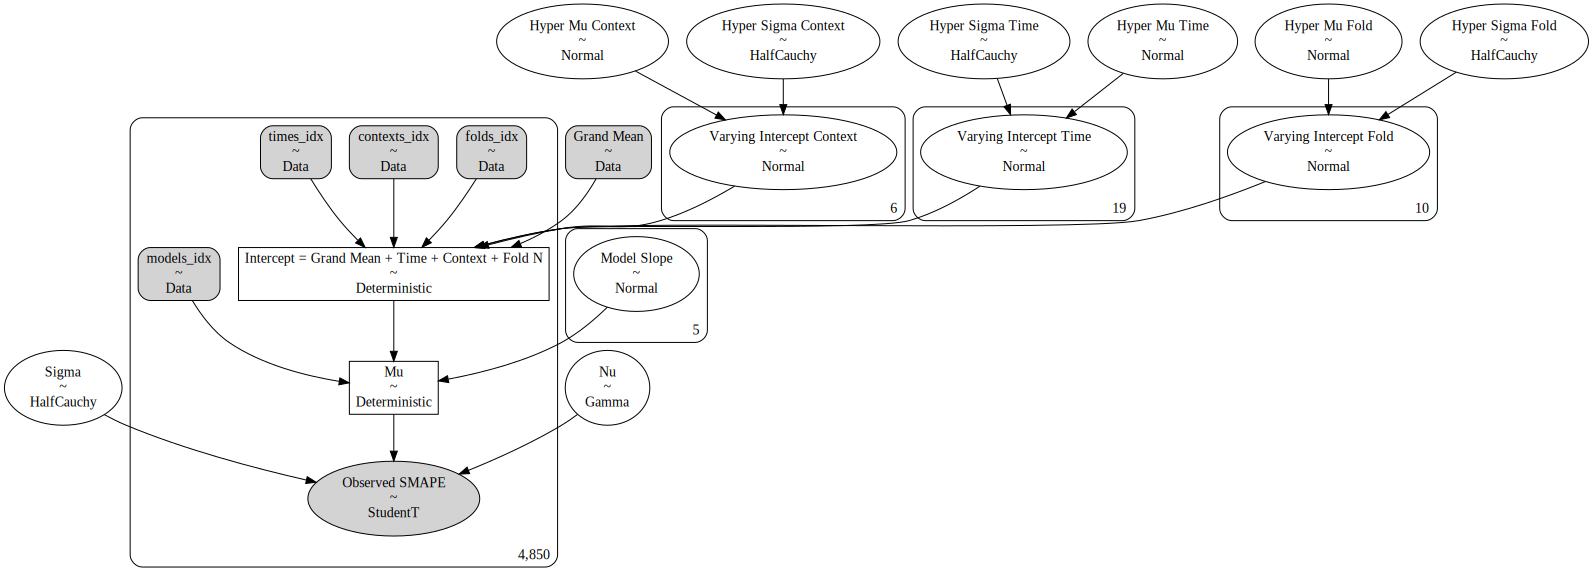

Finished [100%]: Average Loss = 18,274


Future N° Sessions


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Context[0],3.533,0.229,3.135,3.975,0.007,0.005,940.0,983.0,NaN
Varying Intercept Context[1],0.813,0.258,0.286,1.247,0.008,0.006,980.0,1020.0,NaN
Varying Intercept Context[2],-2.223,0.210,-2.593,-1.831,0.006,0.004,1084.0,1024.0,NaN
Varying Intercept Context[3],-5.345,0.243,-5.763,-4.866,0.008,0.005,989.0,823.0,NaN
Varying Intercept Context[4],3.695,0.168,3.361,3.984,0.005,0.004,973.0,850.0,NaN
Varying Intercept Context[5],-3.324,0.257,-3.769,-2.842,0.008,0.006,977.0,959.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Time[0],8.662,0.386,7.894,9.343,0.012,0.009,1015.0,945.0,NaN
Varying Intercept Time[1],2.843,0.384,2.161,3.567,0.012,0.009,952.0,802.0,NaN
Varying Intercept Time[2],0.702,0.348,0.056,1.336,0.011,0.008,952.0,942.0,NaN
Varying Intercept Time[3],-0.477,0.308,-0.997,0.162,0.011,0.007,858.0,944.0,NaN
Varying Intercept Time[4],-0.908,0.306,-1.488,-0.366,0.010,0.007,980.0,863.0,NaN
Varying Intercept Time[5],-1.146,0.303,-1.661,-0.558,0.009,0.007,1048.0,984.0,NaN
Varying Intercept Time[6],-1.658,0.318,-2.205,-1.042,0.010,0.007,1016.0,1015.0,NaN
Varying Intercept Time[7],-1.845,0.311,-2.454,-1.315,0.009,0.007,1116.0,1025.0,NaN
Varying Intercept Time[8],-1.456,0.324,-2.030,-0.807,0.010,0.007,1007.0,1026.0,NaN
Varying Intercept Time[9],-1.118,0.391,-1.809,-0.342,0.013,0.009,883.0,819.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Varying Intercept Fold[0],-0.617,0.189,-0.975,-0.269,0.007,0.005,851.0,881.0,NaN
Varying Intercept Fold[1],-0.643,0.187,-1.004,-0.309,0.006,0.004,958.0,965.0,NaN
Varying Intercept Fold[2],-0.637,0.180,-0.935,-0.278,0.006,0.004,903.0,901.0,NaN
Varying Intercept Fold[3],-0.553,0.178,-0.883,-0.234,0.006,0.004,995.0,820.0,NaN
Varying Intercept Fold[4],-0.686,0.183,-1.037,-0.357,0.006,0.004,873.0,1018.0,NaN
Varying Intercept Fold[5],-0.577,0.177,-0.870,-0.185,0.006,0.004,868.0,982.0,NaN
Varying Intercept Fold[6],-0.473,0.189,-0.812,-0.106,0.006,0.004,985.0,961.0,NaN
Varying Intercept Fold[7],-0.543,0.180,-0.872,-0.209,0.005,0.004,1070.0,944.0,NaN
Varying Intercept Fold[8],-0.584,0.175,-0.884,-0.250,0.005,0.004,981.0,1067.0,NaN
Varying Intercept Fold[9],-0.669,0.182,-1.011,-0.347,0.006,0.004,969.0,1015.0,NaN


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Model Slope[0],14.983,0.310,14.382,15.527,0.010,0.007,1050.0,901.0,NaN
Model Slope[1],0.829,0.562,-0.250,1.817,0.017,0.012,1037.0,1021.0,NaN
Model Slope[2],-3.084,0.187,-3.389,-2.707,0.006,0.004,937.0,915.0,NaN
Model Slope[3],-6.106,0.159,-6.401,-5.815,0.006,0.004,757.0,827.0,NaN
Model Slope[4],-8.776,0.152,-9.043,-8.466,0.005,0.003,1007.0,1017.0,NaN


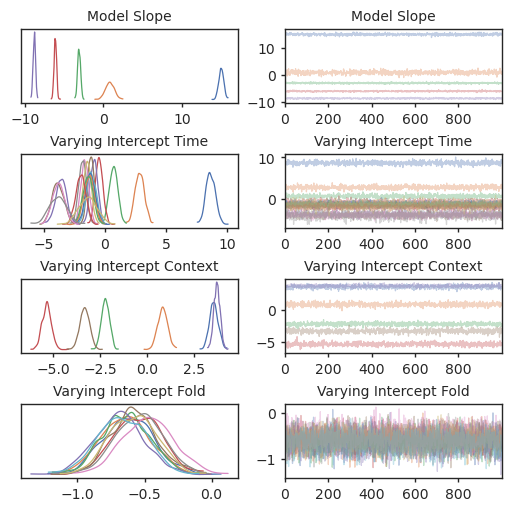

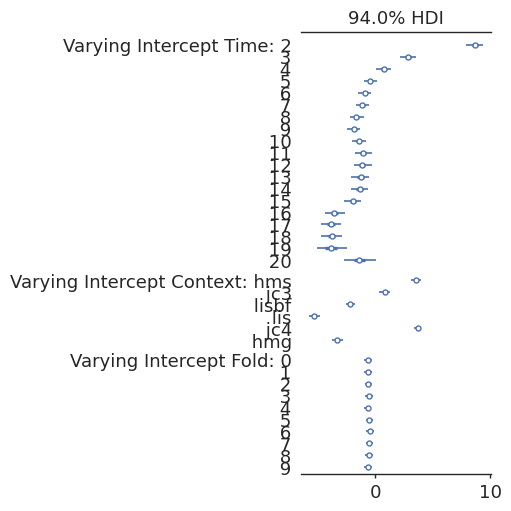

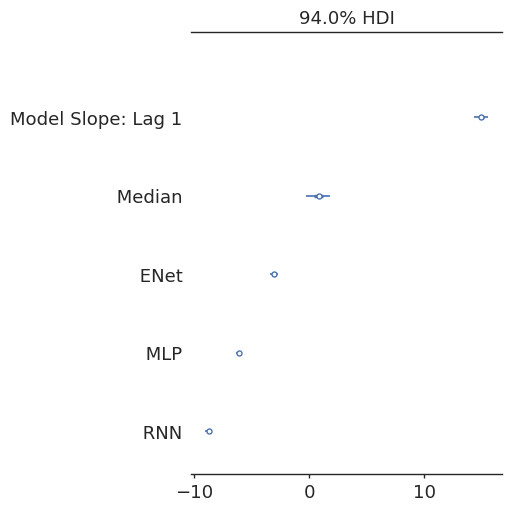

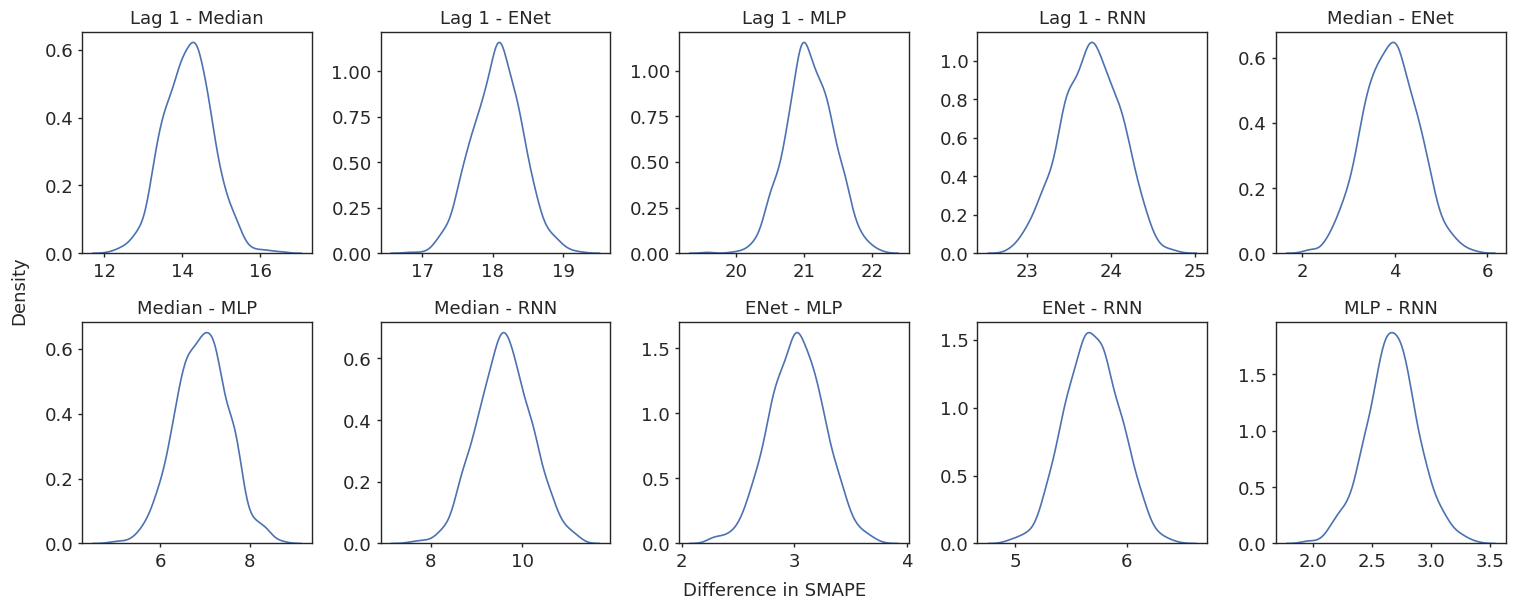

In [17]:
model = LMMPerformance(
    df=final_results, 
    models_column='Model', 
    contexts_column='context', 
    time_column='Session',
    fold_column='fold_n', 
    targets_column='target', 
    outcomes_column='value', 
    robust=True
)
model.analyze(
    targets=final_results['target'].unique(), 
    approx=True, 
    n=100000
)

# Final Plot

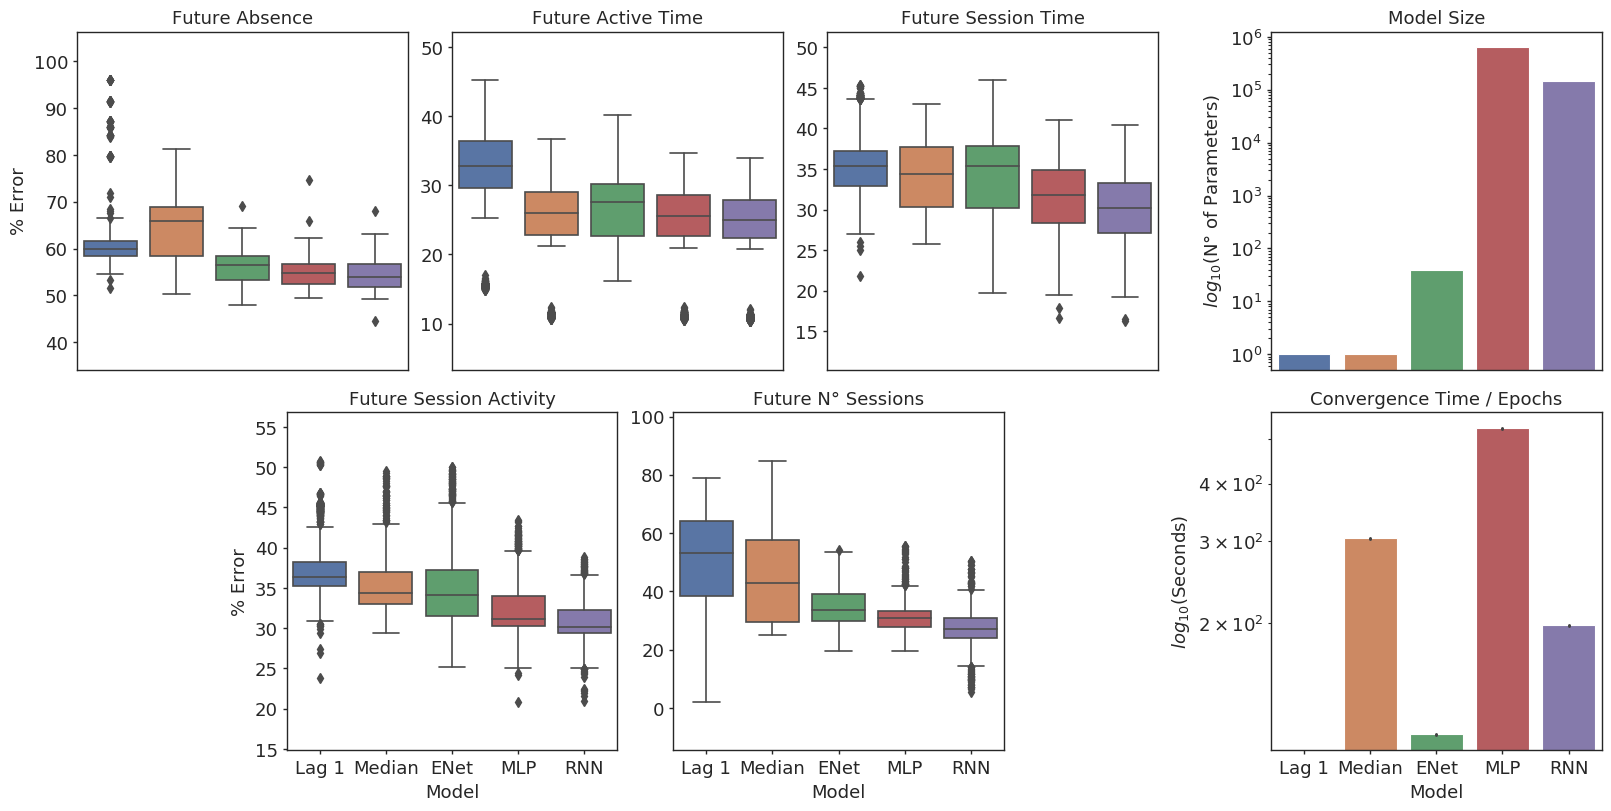

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(16, 8))
spec = fig.add_gridspec(2, 8)


axs_metrics = [
    fig.add_subplot(spec[0, 0:2]),
    fig.add_subplot(spec[0, 2:4]),
    fig.add_subplot(spec[0, 4:6]),
    fig.add_subplot(spec[1, 1:3]),
    fig.add_subplot(spec[1, 3:5])
]
ax_size = fig.add_subplot(spec[0, 6:8])
ax_time = fig.add_subplot(spec[1, 6:8])

########################################################################

index=0
for target, ax_metric in zip(targets, axs_metrics):

    sns.boxplot(
        x='Model',
        y='value',
        data=final_results[final_results['target'] == target],
        order=['Lag 1', 'Median', 'ENet', 'MLP', 'RNN'],
        ax=ax_metric,
        showfliers=True
    )
    y_limits = ax_metric.get_ylim()
    
    ax_metric.set_title(target)
    if index == 0:
        ax_metric.set_ylabel('% Error')
        ax_metric.set_xlabel('')
        ax_metric.set_xticks([])
    elif index == 3:
         ax_metric.set_ylabel('% Error')
    elif index in [1, 2]:
        ax_metric.set_ylabel('')
        ax_metric.set_xlabel('')
        ax_metric.set_xticks([])
    else:
        ax_metric.set_ylabel('')
    ax_metric.margins(y=0.20)
    
    index+=1

sns.barplot(
    x='Model',
    y='parameters',
    data=final_results,
    order=['Lag 1', 'Median', 'ENet', 'MLP', 'RNN'],
    ax=ax_size
)
ax_size.set_xlabel('')
ax_size.set_xticks([])
ax_size.set_yscale('log')
ax_size.set_title('Model Size')
ax_size.set_ylabel('$log_{10}$(N° of Parameters)')

sns.barplot(
    x='Model',
    y='time_epochs',
    data=final_results,
    order=['Lag 1', 'Median', 'ENet', 'MLP', 'RNN'],
    ax=ax_time
)
ax_time.set_xlabel('Model')
ax_time.set_yscale('log')
ax_time.set_title('Convergence Time / Epochs')
ax_time.set_ylabel('$log_{10}$(Seconds)')

plt.savefig(
    'results\\figures\\models_performance\\models_comparison.png',
    dpi=500,
    bbox_inches='tight'
)